In [71]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

import pandas as pd

In [2]:
class WSJ():
    """ Load the WSJ speech dataset
        
        Ensure WSJ_PATH is path to directory containing 
        all data files (.npy) provided on Kaggle.
        
        Example usage:
            loader = WSJ()
            trainX, trainY = loader.train
            assert(trainX.shape[0] == 24590)
            
    """
  
    def __init__(self, path):
        self.dev_set = None
        self.train_set = None
        self.test_set = None
        self.path  = path
        
    @property
    def dev(self):
        if self.dev_set is None:
            self.dev_set = load_raw(self.path, 'dev')
        return self.dev_set

    @property
    def train(self):
        if self.train_set is None:
            self.train_set = load_raw(self.path, 'train')
        return self.train_set
  
    @property
    def test(self):
        if self.test_set is None:
            self.test_set = (np.load(os.path.join(self.path, 'test.npy'), encoding='bytes'), None)
        return self.test_set
    
def load_raw(path, name):
    return (
        np.load(os.path.join(path, '{}.npy'.format(name)), encoding='bytes'), 
        np.load(os.path.join(path, '{}_labels.npy'.format(name)), encoding='bytes')
    )

In [3]:
path = "/home/borowis/s3"
wsj = WSJ(path)

In [4]:
dev = wsj.dev
print(dev[0].shape)
print(dev[1].shape)
print(dev[0][2].shape)
print(dev[0][0])
print(dev[1][0])

(1103,)
(1103,)
(467, 40)
[[ -2.7760592  -10.653754    -9.3995695  ...   0.2363553   -0.5805931
   -0.8171587 ]
 [ -2.2426343   -9.265765    -9.315787   ...  -0.26111507  -0.46208572
   -0.9445448 ]
 [ -2.7435112   -6.7105646  -11.795384   ...  -0.6318717   -0.56550837
   -1.3585529 ]
 ...
 [ -5.409962   -14.84733    -16.779129   ...  -3.2989292   -3.1955743
   -3.436795  ]
 [ -5.069687   -13.877764   -18.607395   ...  -3.1886454   -3.2329483
   -3.5929215 ]
 [ -5.1191835  -16.154802   -19.51888    ...  -1.9263964   -1.8058281
   -2.1436906 ]]
[108 109 110  45  46  47  24  25  26  57  58  59  59  69  69  69  70  70
  70  70  71  71  71  71  81  82  83  54  54  55  56  78  78  78  78  78
  79  80  80  96  96  97  97  97  98  98  98  98  98  99 100 101  24  25
  26  42  43  44  44 120 120 121 121 121 122 102 102 102 102 103 103 103
 103 104 104 104  66  66  67  68 132 132 132 132 133 133 134 134  24  24
  25  25  26  78  78  78  78  79  79  79  79  79  80  80  80  66  67  68
 111 112 113

In [5]:
train = wsj.train

In [38]:
class Dataset_HW1(Dataset):
    
    def __init__(self, loader):
 
        self.x = np.concatenate(loader[0] if len(loader) == 2 else loader)
        self.y = np.concatenate(loader[1]) if (len(loader) == 2 and loader[1] is not None) else None
        
    def __len__(self):
        return len(self.x)
      
    def __getitem__(self, idx):

        data = torch.from_numpy(self.x[idx])
        
        if self.y is not None:
            label = torch.from_numpy(np.array(self.y[idx]))
            return data, label
          
        else:
            return data

In [7]:
val_ds = Dataset_HW1(dev)
val_loader = DataLoader(val_ds, shuffle=True, batch_size=256, num_workers=4, pin_memory=True)

In [8]:
train_ds = Dataset_HW1(train)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=256, num_workers=4, pin_memory=True)

In [9]:
class Simple_MLP(nn.Module):
    def __init__(self):
        super(Simple_MLP, self).__init__()
        
        self.fc1 = nn.Linear(40, 1024)
        self.bnorm1 = nn.BatchNorm1d(1024)
        #self.dp1 = nn.Dropout(p=0.2)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.bnorm2 = nn.BatchNorm1d(1024)
        
        #self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(1024, 138)
    
    def forward(self, x):
        x = x.view(-1, 40) # Flatten the input
        x = self.bnorm1(F.relu(self.fc1(x)))
        #x = self.dp1(x)
        x = self.bnorm2(F.relu(self.fc2(x)))
        #x = self.dp2(x)
        x = F.log_softmax(self.fc3(x))
        return x

In [10]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

In [11]:
model = Simple_MLP()
model.apply(init_xavier)

criterion = nn.CrossEntropyLoss()
print(model)

optimizer = optim.Adam(model.parameters())

Simple_MLP(
  (fc1): Linear(in_features=40, out_features=1024, bias=True)
  (bnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=138, bias=True)
)


In [12]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.cuda()
        target = target.long().cuda()

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [13]:
def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.cuda()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.long().cuda()

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, '%')
        return running_loss, acc

In [ ]:
n_epochs = 2
train_loss = []
val_loss = []
val_acc = []

In [18]:
for i in range(5):
    tl = train_epoch(model, train_loader, criterion, optimizer)
    vl, va = test_model(model, val_loader, criterion)
    
    train_loss.append(tl)
    val_loss.append(vl)
    val_acc.append(va)
    print('='*20)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Loss:  2.6688791010938377 Time:  172.86115264892578 s
Validation Loss:  2.70669318211922
Validation Accuracy:  29.774508661365555 %
Training Loss:  2.652919987399279 Time:  173.57302689552307 s
Validation Loss:  2.702902802728102
Validation Accuracy:  30.08453684031233 %
Training Loss:  2.641664927235973 Time:  173.22914934158325 s
Validation Loss:  2.70090117062483
Validation Accuracy:  30.00878537682991 %
Training Loss:  2.6331728864706556 Time:  172.66131234169006 s
Validation Loss:  2.6908922675918667
Validation Accuracy:  30.33106527176398 %
Training Loss:  2.626035803525726 Time:  173.71867871284485 s
Validation Loss:  2.6920187277274197
Validation Accuracy:  30.12607314573267 %


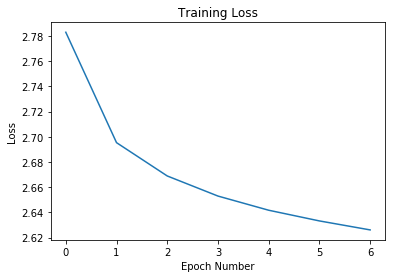

In [19]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)

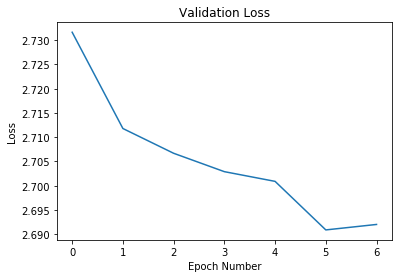

In [20]:
plt.title('Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(val_loss)

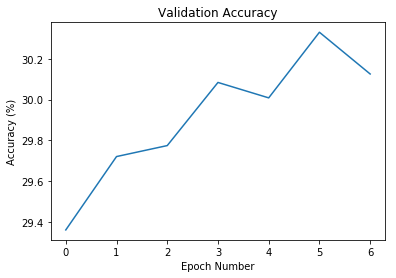

In [21]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(val_acc)

In [39]:
test = wsj.test
test_ds = Dataset_HW1(test)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=256, num_workers=4, pin_memory=True)

In [67]:
def inference(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.cuda()

        preds = []
        for batch_idx, data in enumerate(test_loader):   
            data = data.cuda()
            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            preds.append(predicted.cpu().numpy())

        return np.concatenate(preds)

In [68]:
preds = inference(model, test_loader)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [72]:
df = pd.DataFrame(preds)

In [75]:
df.to_csv(path + "/subm1.csv", header = ['label'], index_label='id')